# 9. Pattern matching, local maxima

Sometimes threholding and binary operations are not appropriate tools to segment image features. This is particularly true when the object to be detected has as specific shape but a very variable intensity or if the image has low contrast. In that case it is useful to attempt to build a "model" of the object and look for similar shapes in the image. It is very similar in essence to convolution, however the operation is normalized so that after filtering every pixel is assigned a value between -1 (anti-correlation) to +1 perfect correlation. One can then look for local matching maxima to identify objects.

In [1]:
from skimage.feature import match_template, peak_local_max
import skimage.io as io

In [2]:
import numpy as np
import matplotlib.pyplot as plt
plt.gray()
from skimage.external.tifffile import TiffFile

<Figure size 432x288 with 0 Axes>

## 9.1 Virus on electron microscopy

Electron microscopy is a typical case where pixel intensity cannot be directly used for segmentation. For example in the following picture of a virus (obtained from [here](http://res.publicdomainfiles.com/pdf_view/29/13512183019720.jpg)), even though we see the virus as white disks, many other regions are as bright.

In [3]:
#load the image to process
image = io.imread('../Data/virus_EM.tif')


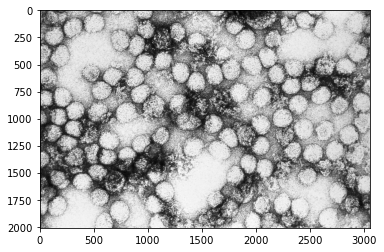

In [4]:
plt.imshow(image);

What is unique to the virus is the shape of the objects. So let's try to make a model of them to do template matching. Essentially a virus appears as a white disk surrounded by a thin dark line:

In [5]:
radius = 90

template = np.zeros((220,220))
center = [(template.shape[0]-1)/2,(template.shape[1]-1)/2]
Y, X = np.mgrid[0:template.shape[0],0:template.shape[1]]
dist_from_center = np.sqrt((X - center[0])**2 + (Y-center[1])**2)
template[dist_from_center<=radius] = 1
template[dist_from_center>radius+3] = 1

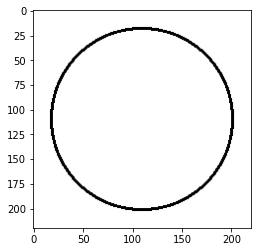

In [6]:
plt.imshow(template)

Now we do the template matching. Note that we specify the option ```pad_input``` to make sure the coordinates of the local maxima is not affected by boreder effects (try to turn it to ```False``` to see the effecf):

In [7]:
matched = match_template(image=image, template=template, pad_input=True)

And this is how the matched image looks like. Wherever there's a particle a local maximum appears.

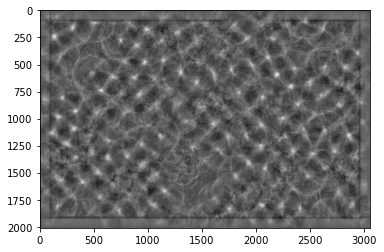

In [8]:
plt.imshow(matched)

We can try to detect the local maxima to have the position of each particle. For that we use the scipy ```peak_local_max``` function. We specify that two maximia cannot be closer than 20 pixels (```min_distance```) and we also set a threshold on the quality of matching (```threshold_abs```). We also want to recover a list of indices rather than a binary mask of local maxima.

In [9]:
local_max_indices = peak_local_max(matched, min_distance=60,indices=True, threshold_abs=0.1)

Finally we can plot the result:

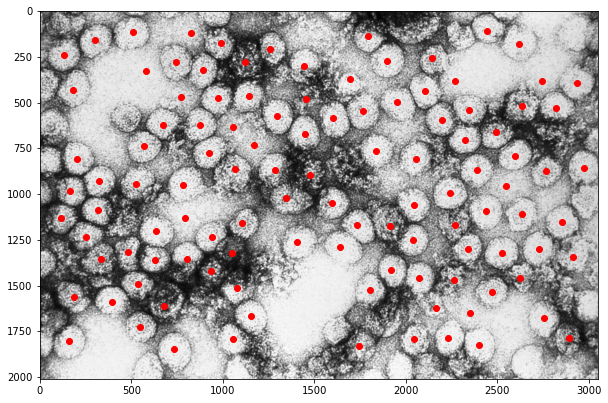

In [10]:
plt.figure(figsize=(10,10))
plt.imshow(image)
plt.plot(local_max_indices[:,1],local_max_indices[:,0],'ro')
plt.show()

## 9.2 Fluorescence microscopy

In the following example we are looking at a nuclei imaged by fluorescence microscopy. Here, intensity can clearly be used for segmentation but is going to lead to merged objects when they are too close. To identify each nucleus in a first step before actual segmentation, we can again use template matching.

In [11]:
import skimage.io as io

In [12]:
image = io.imread('../Data/BBBC007_v1_images/A9/A9 p9d.tif')

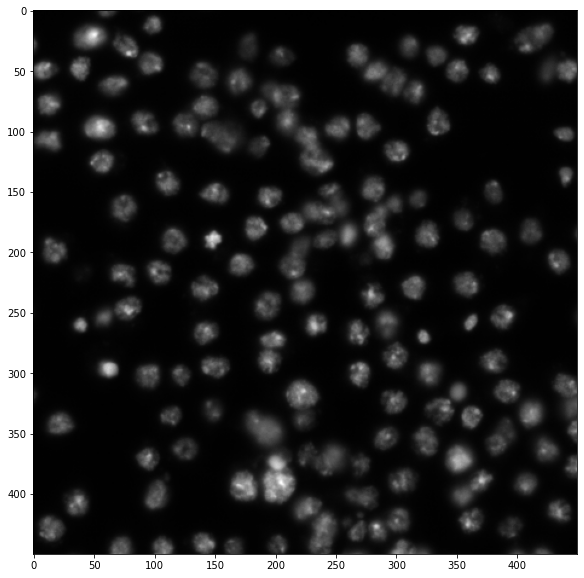

In [13]:
plt.figure(figsize=(10,10))
plt.imshow(image);

In this image, nuclei have radius of around 10 pixels. We can generate again a template:

In [14]:
radius = 10

template = np.zeros((25,25))
center = [(template.shape[0]-1)/2,(template.shape[1]-1)/2]
Y, X = np.mgrid[0:template.shape[0],0:template.shape[1]]
dist_from_center = np.sqrt((X - center[0])**2 + (Y-center[1])**2)
template[dist_from_center<=radius] = 1

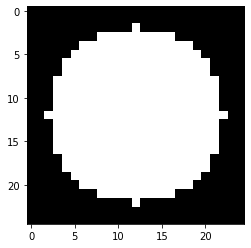

In [15]:
plt.imshow(template, cmap = 'gray')
plt.show()

In [16]:
matched = match_template(image=image, template=template, pad_input=True)

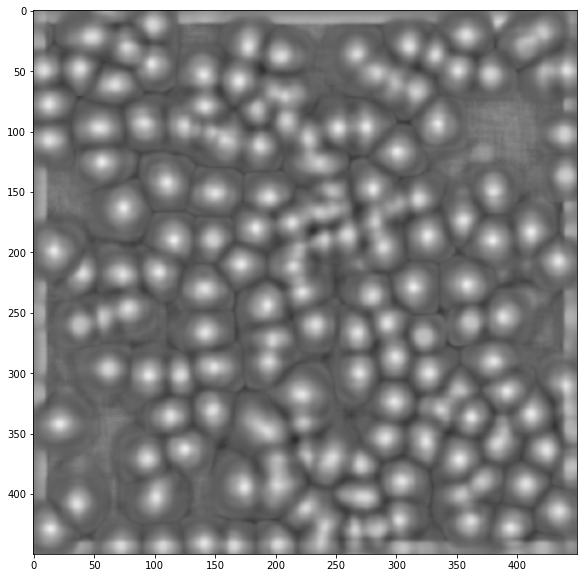

In [17]:
plt.figure(figsize=(10,10))
plt.imshow(matched, cmap = 'gray', vmin = -1, vmax = 1);

In [18]:
local_max = peak_local_max(matched, min_distance=10,indices=False)
local_max_indices = peak_local_max(matched, min_distance=10,indices=True)

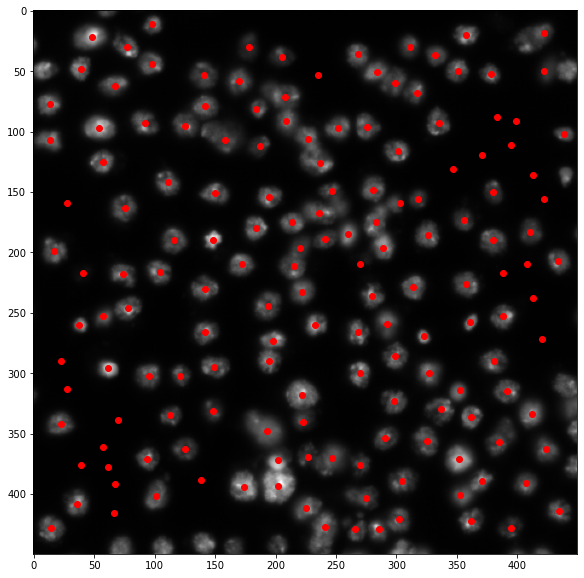

In [19]:
plt.figure(figsize=(10,10))
plt.imshow(image)
plt.plot(local_max_indices[:,1],local_max_indices[:,0],'ro');

We didn't set any threshold on what intensity local maxima should have, therefore we have a few detected cells that are clearly in the background. We could masks those using a rough threshold.

In [20]:
import skimage.filters
import skimage.morphology

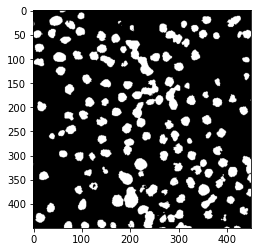

In [21]:
otsu = skimage.filters.threshold_otsu(image)

otsu_mask = image>otsu

plt.imshow(otsu_mask);

We can dilate a bit all the regions to make sure we fill the holes and do not cut off dim cells

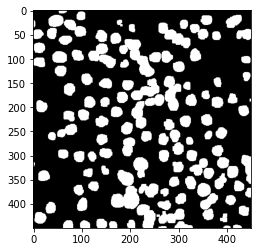

In [22]:
otsu_mask = skimage.morphology.binary_dilation(otsu_mask, np.ones((5,5)))
plt.imshow(otsu_mask);

Now we can mask the image returned by the peak finder:

In [23]:
masked_peaks = local_max & otsu_mask

And recover the coordinates of the detected peaks:

In [24]:
peak_coords = np.argwhere(masked_peaks)

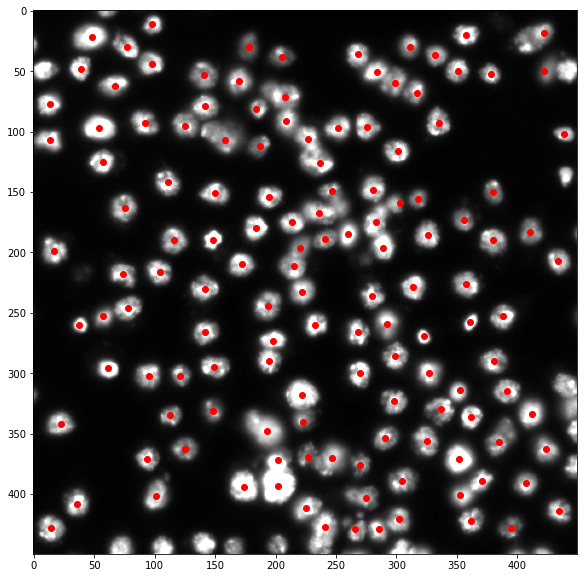

In [25]:
plt.figure(figsize=(10,10))
plt.imshow(image, cmap = 'gray',vmax = 100)
plt.plot(peak_coords[:,1],peak_coords[:,0],'ro');